In [109]:
import os
import math
import random as rand
from tqdm import tqdm, trange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, TFBertForSequenceClassification
from datasets import Dataset
import evaluate

import tensorflow as tf

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Data Loading

In [110]:
dataset = 'abstract'

In [111]:
df = pd.read_pickle("data/train_{}.pkl".format(dataset))

In [112]:
df.head()

,label,text
0,1,BACKGROUND: The adult versions EQ-5D-3L and EQ...
1,0,PURPOSE: The EQ-5D-3L and 5L are widely used g...
2,1,BACKGROUND: The role of artisanal and small-sc...
3,1,OBJECTIVE: To assess measurement properties of...
4,1,Impaired health-related quality of life (HRQoL...


In [113]:
train_dataset = Dataset.from_pandas(df)

In [114]:
train_dataset[0]

{'label': 1,
 'text': 'BACKGROUND: The adult versions EQ-5D-3L and EQ-5D-5L have been extensive compared. This is not the case for the EQ-5D youth versions. The study aim was to compare the measurement properties and responsiveness of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients. METHODS: A sample of patients 8-16\xa0years old with different diseases and a wide range of disease severity was asked to complete EQ-5D-Y-3L, EQ-5D-Y-5L, PedsQL Generic Core Scale, and selected, appropriate disease-specific instruments, three times. EQ-5D-Y-3L and EQ-5D-Y-5L were compared in terms of: feasibility, (re-)distribution properties, discriminatory power, convergent validity, test-retest reliability, and responsiveness. RESULTS: 286 participating patients suffered from one of the following diseases: major beta-thalassemia, haemophilia, acute lymphoblastic leukaemia, acute illness. Missing responses were comparable between versions of the EQ-5D-Y, suggesting comparable feasibility. The number of 

In [115]:
#random stratified validation subset split
#_diff = 1
#while _diff >= .02:
#    tts = train_dataset.train_test_split(test_size=.15, shuffle=True)
#    _train_ratio, _val_ratio = np.sum(tts["train"]["label"]) / len(tts["train"]["label"]), np.sum(tts["test"]["label"]) / len(tts["test"]["label"])
#    _diff = abs(_train_ratio - _val_ratio)
#    print(_train_ratio, _val_ratio, _diff)
#
#train_dataset = tts["train"]
#val_dataset = tts["test"]


#subsets should be fixed for all tests
_val_ids = [2, 7, 24, 32, 36, 47, 49, 59, 61, 71, 72, 86, 90, 95, 96]
train_dataset = Dataset.from_pandas(df[~df.index.isin(_val_ids)])
val_dataset = Dataset.from_pandas(df[df.index.isin(_val_ids)])

In [116]:
np.sum(train_dataset["label"]) / len(train_dataset["label"]), np.sum(val_dataset["label"]) / len(val_dataset["label"])

(0.611764705882353, 0.6)

In [117]:
train_dataset[0]

{'label': 1,
 'text': 'BACKGROUND: The adult versions EQ-5D-3L and EQ-5D-5L have been extensive compared. This is not the case for the EQ-5D youth versions. The study aim was to compare the measurement properties and responsiveness of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients. METHODS: A sample of patients 8-16\xa0years old with different diseases and a wide range of disease severity was asked to complete EQ-5D-Y-3L, EQ-5D-Y-5L, PedsQL Generic Core Scale, and selected, appropriate disease-specific instruments, three times. EQ-5D-Y-3L and EQ-5D-Y-5L were compared in terms of: feasibility, (re-)distribution properties, discriminatory power, convergent validity, test-retest reliability, and responsiveness. RESULTS: 286 participating patients suffered from one of the following diseases: major beta-thalassemia, haemophilia, acute lymphoblastic leukaemia, acute illness. Missing responses were comparable between versions of the EQ-5D-Y, suggesting comparable feasibility. The number of 

In [118]:
df = pd.read_pickle("data/test_{}.pkl".format(dataset))

In [119]:
test_dataset = Dataset.from_pandas(df)

In [120]:
np.sum(test_dataset["label"]) / len(test_dataset["label"])

0.6

# Preparation for training

In [121]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

In [122]:
#def preprocess_function(examples):
#    return tokenizer(examples["text"], truncation=True, padding=True)

In [123]:
#encodings = dataset.map(preprocess_function, batched=True)
train_encodings = tokenizer(train_dataset["text"], truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_dataset["text"], truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_dataset["text"], truncation=True, padding=True, max_length=512)

In [124]:
len(train_encodings[0]), len(train_encodings[1]), len(train_encodings[2])

(512, 512, 512)

In [125]:
np.mean([np.sum([t == '[PAD]' for t in train_encodings[e].tokens]) for e in range(0,80)])

102.95

In [126]:
train_labels = train_dataset["label"]
val_labels = val_dataset["label"]
test_labels = test_dataset["label"]

In [127]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).shuffle(100).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

In [128]:
model = TFBertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", from_pt=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
model.layers[0].trainable = False

In [130]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 1,538
Non-trainable params: 108,310,272
_________________________________________________________________


In [131]:
model.compile(optimizer="adam", loss=loss, metrics=['sparse_categorical_accuracy'])

In [132]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
hist = model.fit(train_dataset, 
                 epochs=1000, 
                 validation_data=val_dataset,
                 callbacks=[es],
                 verbose=0)

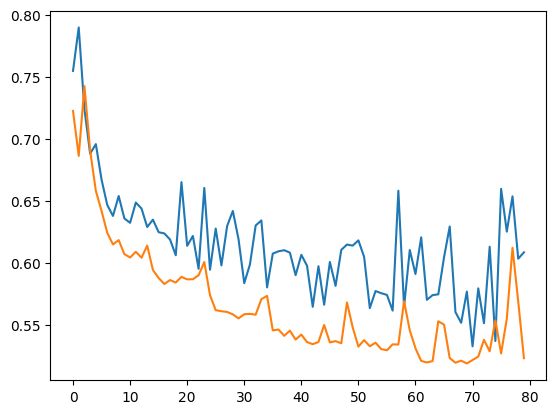

In [133]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

### results

In [134]:
model.evaluate(test_dataset)

7/7 [==============================] - 30s 4s/step - loss: 0.6976 - sparse_categorical_accuracy: 0.6000


[0.6976392269134521, 0.6000000238418579]

In [135]:
predraw = model.predict(test_dataset, verbose=0)

In [136]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

In [137]:
predsoftmax = softmax(predraw.logits.astype(np.float32))

In [138]:
test_labels = np.array(test_labels)

In [139]:
test_predictions = np.argmax(predraw.logits, axis=1)

In [140]:
np.sum(np.argmax(predsoftmax, axis=1) == np.array(test_labels))

60

In [141]:
confusionMatrix = confusion_matrix(test_labels,test_predictions)

In [142]:
macroF1 = f1_score(test_labels,test_predictions, average = 'macro')
microF1 = f1_score(test_labels,test_predictions, average = 'micro')
weightedF1 = f1_score(test_labels,test_predictions, average = 'weighted')

macroRecall = recall_score(test_labels, test_predictions, average='macro')
microRecall = recall_score(test_labels, test_predictions, average='micro')
weightedRecall = recall_score(test_labels, test_predictions, average='weighted')

macroPrecision = precision_score(test_labels, test_predictions, average='macro')
microPrecision = precision_score(test_labels, test_predictions, average='micro')
weightedPrecision = precision_score(test_labels, test_predictions, average='weighted')


print ("Confusion Matrix:", "\n", confusionMatrix, "\n", 
       "F Scores:", "\n", "macro F1:", macroF1,"micro F1:", microF1, "weighted F1:", weightedF1, "\n",
       "Recall scores:", "\n", "macro Recall:", macroRecall, "micro Recall:", microRecall, "weighted Recall:", weightedRecall, "\n",
       "Precision scores", "\n", "macro Precision:", macroPrecision, "micro Precision:", microPrecision, "weighted Precision:", weightedPrecision)

Confusion Matrix: 
 [[ 8 32]
 [ 8 52]] 
 F Scores: 
 macro F1: 0.503968253968254 micro F1: 0.6 weighted F1: 0.5476190476190477 
 Recall scores: 
 macro Recall: 0.5333333333333333 micro Recall: 0.6 weighted Recall: 0.6 
 Precision scores 
 macro Precision: 0.5595238095238095 micro Precision: 0.6 weighted Precision: 0.5714285714285715


In [143]:
#TODO: collect results and write to a log

In [144]:
with open("init_results-{}-{}.txt".format("biobert", dataset), "w") as text_file:
    text_file.write("{};{};{};{};{}".format("biobert", dataset, weightedPrecision, weightedRecall, weightedF1))